In [38]:
!pip install opencv-python mediapipe scikit-learn matplotlib seabornM

     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     -------- ------------------------------ 61.4/293.3 kB 1.1 MB/s eta 0:00:01
     -------------------------- ----------- 204.8/293.3 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 2.0 MB/s eta 0:00:00
  Obtaining dependency information for pandas>=0.25 from https://files.pythonhosted.org/packages/c3/6c/ea362eef61f05553aaf1a24b3e96b2d0603f5dc71a3bd35688a24ed88843/pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ------------------------------- ------ 286.7/341.8 kB 8.9 MB/s eta 0:00:01
     ----------------------------------

In [5]:
import tensorflow as tf
!pip install --upgrade mediapipe
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic #Holistic model
mp_drawing = mp.solutions.drawing_utils #drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles #drawing styles

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                 # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_styled_landmarks(image, results):
    
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             None,
                             connection_drawing_spec=mp.solutions.drawing_styles
                            .get_default_face_mesh_tesselation_style()
                             ) 
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             None,
                             connection_drawing_spec=mp.solutions.drawing_styles
                            .get_default_face_mesh_contours_style()
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 


In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        #Read feed
        ret, frame = cap.read()

        #Make Detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        #Show feed
        cv2.imshow('WebCam Feed', image)

        #Escape from loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [8]:
draw_styled_landmarks(frame, results)

In [10]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

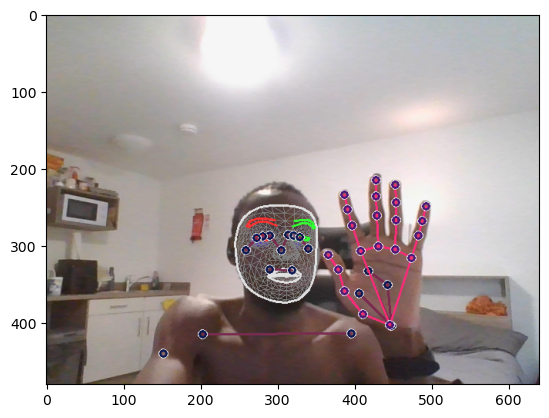

In [18]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [12]:
result_test = extract_keypoints(results)

In [13]:
np.save('0', result_test)

In [43]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('SLR_Data') 

# Actions that we try to detect
actions = np.array(['Varies', 'Maybe', 'Depends', 'Useful', 'Meet', 'Please'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [44]:
for action in actions: 
#     dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        path = os.path.join(DATA_PATH, action, str(sequence))
        if not os.path.exists(path):
            try: 
                os.makedirs(path)
            except Exception as e:
                print('Error creating directory:', e)

In [8]:
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
# cap.set(cv2.CAP_PROP_FPS, 30)
# cap.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc(*'MJPG'))

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
     # Loop through actions
    for action in actions: 
        
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num) + '.npy')
                
                # Check if directory already exists
                if not os.path.exists(npy_path):
                    #Read feed
                    ret, frame = cap.read()

                    #Make Detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)

                    # NEW Apply wait logic
                    if frame_num == 0: 
                        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        cv2.waitKey(900)
                    else:
#                         cv2.waitKey(500)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                     #Show feed
                    cv2.imshow('WebCam Feed', image)
                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                #Escape from loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                   
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [208]:
cap.release()
cv2.destroyAllWindows()

In [45]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [99]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Varies': 0, 'Maybe': 1, 'Depends': 2, 'Useful': 3, 'Meet': 4, 'Please': 5}

In [100]:
sequences, labels = [], []
for action in actions:
#     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [101]:
X = np.array(sequences)
X.shape

(180, 30, 1662)

In [102]:
y = to_categorical(labels).astype(int)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [105]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30,1662)))
# model.add(LSTM(128, return_sequences=True, activation='tanh'))
# model.add(LSTM(64, return_sequences=False, activation='tanh'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(32, activation='tanh'))
# model.add(Dense(actions.shape[0], activation='softmax'))

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [112]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [113]:
epoch_value = 300
# loss_history = []
# accuracy_history = []
history = model.fit(X_train, y_train, epochs=epoch_value, validation_split=0.1, callbacks=[early_stopping])
# print(f"Epoch {epoch + 1}/{epoch_value} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")


# model.fit(X_train, y_train, epochs=epoch_value, callbacks=[tb_callback])

Epoch 1/300
5/5 [==============================] - 3s 250ms/step - loss: 9.7457 - categorical_accuracy: 0.1634 - val_loss: 5.6453 - val_categorical_accuracy: 0.1667
Epoch 2/300
5/5 [==============================] - 1s 132ms/step - loss: 4.7864 - categorical_accuracy: 0.1242 - val_loss: 2.8646 - val_categorical_accuracy: 0.2778
Epoch 3/300
5/5 [==============================] - 1s 139ms/step - loss: 2.3210 - categorical_accuracy: 0.1830 - val_loss: 2.6252 - val_categorical_accuracy: 0.0556
Epoch 4/300
5/5 [==============================] - 1s 150ms/step - loss: 1.9841 - categorical_accuracy: 0.2418 - val_loss: 2.1086 - val_categorical_accuracy: 0.0556
Epoch 5/300
5/5 [==============================] - 1s 133ms/step - loss: 1.9011 - categorical_accuracy: 0.1503 - val_loss: 1.9169 - val_categorical_accuracy: 0.1111
Epoch 6/300
5/5 [==============================] - 1s 130ms/step - loss: 1.8406 - categorical_accuracy: 0.1503 - val_loss: 2.1110 - val_categorical_accuracy: 0.0556
Epoch 7/30

5/5 [==============================] - 1s 145ms/step - loss: 1.6137 - categorical_accuracy: 0.1895 - val_loss: 1.7027 - val_categorical_accuracy: 0.1111
Epoch 51/300
5/5 [==============================] - 1s 135ms/step - loss: 1.5274 - categorical_accuracy: 0.2680 - val_loss: 1.5950 - val_categorical_accuracy: 0.1667
Epoch 52/300
5/5 [==============================] - 1s 168ms/step - loss: 1.4547 - categorical_accuracy: 0.3268 - val_loss: 1.6599 - val_categorical_accuracy: 0.1111


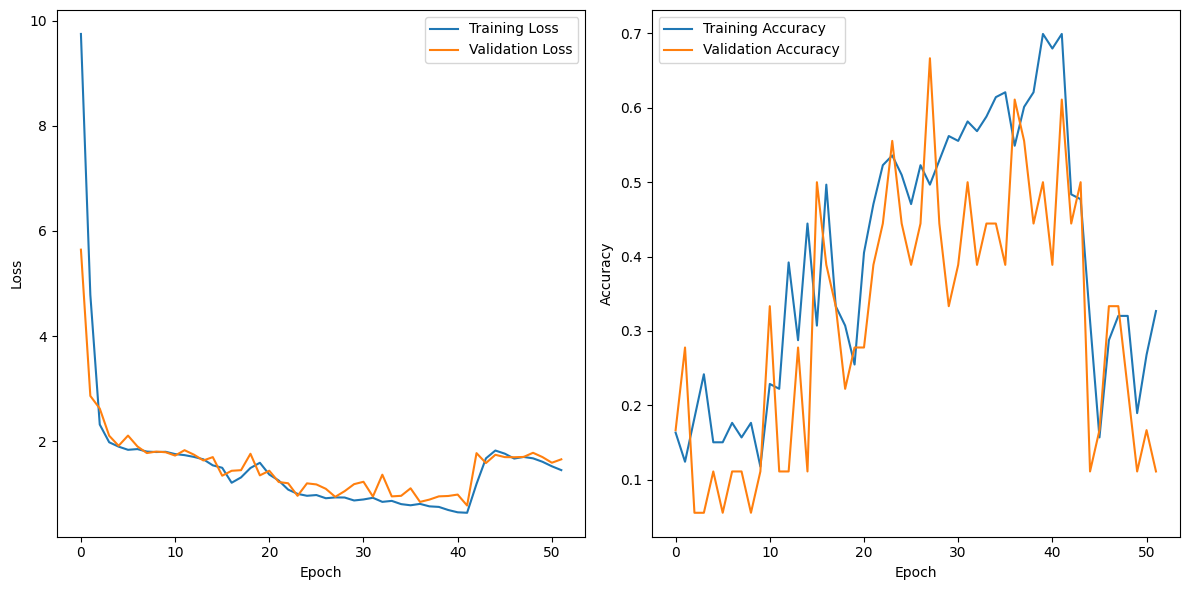

In [114]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                                 
Total params: 477,414
Trainable params: 477,414
Non-trainable params: 0
_________________________________________________________________


In [115]:
res = model.predict(X_test)

1/1 [==============================] - 0s 259ms/step


In [116]:
actions[np.argmax(res[4])]

'Varies'

In [117]:
actions[np.argmax(y_test[4])]

'Meet'

In [261]:
model.save('SLR.MODEL')

INFO:tensorflow:Assets written to: SLR.MODEL\assets


INFO:tensorflow:Assets written to: SLR.MODEL\assets


In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [119]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 37ms/step


In [120]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

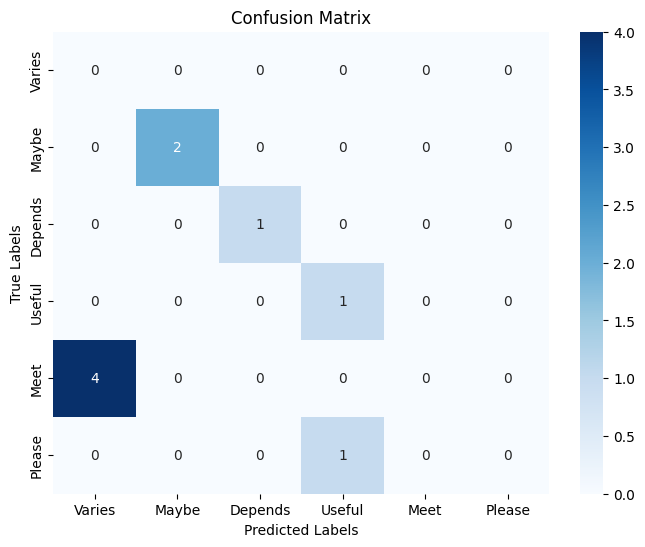

In [121]:
conf_matrix = confusion_matrix(ytrue, yhat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [122]:
accuracy = accuracy_score(ytrue, yhat)
print("Accurary:", accuracy)
precision = precision_score(ytrue, yhat, average='weighted')  # You can specify the averaging method: 'weighted', 'micro', 'macro', etc.
print("Precision:", precision)

# Calculate recall
recall = recall_score(ytrue, yhat, average='weighted')  # You can specify the averaging method.
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(ytrue, yhat, average='weighted')  # You can specify the averaging method.
print("F1 Score:", f1)

Accurary: 0.4444444444444444
Precision: 0.3888888888888889
Recall: 0.4444444444444444
F1 Score: 0.4074074074074074


C:\Users\Ameen\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ameen\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
colors = [(245,117,16), (117,245,16), (16,117,245), (14, 200, 100), (300, 234, 58),(360, 55, 235)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
# cap.set(cv2.CAP_PROP_FPS, 30)
# cap.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc(*'MJPG'))
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5


# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

cap.release()
cv2.destroyAllWindows()